<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Check-your-sample-table-(i.e.-metadata-file)" data-toc-modified-id="Check-your-sample-table-(i.e.-metadata-file)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Check your sample table (i.e. metadata file)</a></span></li><li><span><a href="#Check-your-TRN" data-toc-modified-id="Check-your-TRN-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Check your TRN</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load the data</a></span></li></ul></li><li><span><a href="#Regulatory-iModulons" data-toc-modified-id="Regulatory-iModulons-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regulatory iModulons</a></span></li><li><span><a href="#Functional-iModulons" data-toc-modified-id="Functional-iModulons-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Functional iModulons</a></span><ul class="toc-item"><li><span><a href="#GO-Enrichments" data-toc-modified-id="GO-Enrichments-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>GO Enrichments</a></span></li><li><span><a href="#KEGG-Enrichments" data-toc-modified-id="KEGG-Enrichments-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>KEGG Enrichments</a></span><ul class="toc-item"><li><span><a href="#Load-KEGG-mapping" data-toc-modified-id="Load-KEGG-mapping-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Load KEGG mapping</a></span></li><li><span><a href="#Perform-enrichment" data-toc-modified-id="Perform-enrichment-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Perform enrichment</a></span></li><li><span><a href="#Convert-KEGG-IDs-to-human-readable-names" data-toc-modified-id="Convert-KEGG-IDs-to-human-readable-names-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Convert KEGG IDs to human-readable names</a></span></li><li><span><a href="#Save-files" data-toc-modified-id="Save-files-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Save files</a></span></li></ul></li></ul></li><li><span><a href="#Check-for-single-gene-iModulons" data-toc-modified-id="Check-for-single-gene-iModulons-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check for single gene iModulons</a></span></li><li><span><a href="#Compare-against-published-iModulons" data-toc-modified-id="Compare-against-published-iModulons-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Compare against published iModulons</a></span></li><li><span><a href="#Save-iModulon-object" data-toc-modified-id="Save-iModulon-object-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Save iModulon object</a></span></li><li><span><a href="#Coming-soon" data-toc-modified-id="Coming-soon-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Coming soon</a></span></li></ul></div>

# Setup
This IPython notebook will walk through the steps of characterizing iModulons through semi-automated tools. You will need:
* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

Optional:
* iModulon table (if you already have some characterized iModulons)

In [1]:
from pymodulon.core import IcaData
from os import path
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm

In [2]:
# Enter the location of your data here
data_dir = '../data/'

## Check your sample table (i.e. metadata file)
Your metadata file will probably have a lot of columns, most of which you may not care about. Feel free to save a secondary copy of your metadata file with only columns that seem relevant to you. The two most important columns are:
1. `project`
2. `condition`

Make sure that these columns exist in your metadata file

In [3]:
df_metadata = pd.read_csv(path.join(data_dir,'metadata_qc.csv'),index_col=0)
df_metadata[['project','condition']].head()

,project,condition
SRX1828913,algU_regulon,empty_vector
SRX1828914,algU_regulon,algU_del_sacB
SRX1828915,algU_regulon,empty_vector
SRX1828916,algU_regulon,algU_del_sacB
SRX1828917,algU_regulon,empty_vector


In [4]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


## Check your TRN

Each row of the TRN file represents a regulatory interaction.  
**Your TRN file must have the following columns:**
1. `regulator` - Name of regulator (`/` or `+` characters will be converted to `;`)
1. `gene_id` - Locus tag of gene being regulated

The following columns are optional, but are helpful to have:
1. `regulator_id` - Locus tag of regulator
1. `gene_name` - Name of gene (can automatically update this using `name2num`)
1. `direction` - Direction of regulation ('+' for activation, '-' for repression, '?' or NaN for unknown)
1. `evidence` - Evidence of regulation (e.g. ChIP-exo, qRT-PCR, SELEX, Motif search)
1. `PMID` - Reference for regulation

You may add any other columns that could help you. TRNs may be saved as either CSV or TSV files. See below for an example:

In [5]:
df_trn = pd.read_csv(path.join(data_dir,'TRN.csv'), index_col=0)
df_trn.head()

,regulator_old,gene_id_old,regulator,gene_id
0,PSPTO1158,PSPTO1157,PSPTO_RS06115,PSPTO_RS06110
1,PSPTO1158,PSPTO1156,PSPTO_RS06115,PSPTO_RS06105
2,PSPTO1158,PSPTO1155,PSPTO_RS06115,PSPTO_RS06100
3,PSPTO1158,PSPTO1154,PSPTO_RS06115,PSPTO_RS06095
4,PSPTO1158,PSPTO1153,PSPTO_RS06115,PSPTO_RS06090


The `regulator` and `gene_id` must be filled in for each row

In [6]:
print(df_trn.regulator.notnull().all())
print(df_trn.gene_id.notnull().all())

True
True


## Load the data
You're now ready to load your IcaData object!

If you don't have a TRN (or have a very minimal TRN), use `threshold_method = 'kmeans'`

In [38]:
ica_data = IcaData(M = path.join(data_dir,'M.csv'),
                   A = path.join(data_dir,'A.csv'),
                   X = path.join(data_dir,'X.csv'),
                   gene_table = path.join(data_dir,'gene_info.csv'),
                   sample_table = path.join(data_dir,'metadata_qc.csv'),
                   trn = path.join(data_dir,'TRN.csv'))

# Regulatory iModulons
Use `compute_trn_enrichment` to automatically check for Regulatory iModulons. The more complete your TRN, the more regulatory iModulons you'll find.

In [39]:
ica_data.compute_trn_enrichment(save=True)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,0,PSPTO_RS01865,9.808664e-10,1.039718e-07,0.500000,0.151515,0.232558,5.0,10.0,33.0,1.0
1,0,PSPTO_RS27090,4.024147e-09,2.132798e-07,0.800000,0.121212,0.210526,4.0,5.0,33.0,1.0
2,0,PSPTO_RS06115,1.202499e-08,4.248829e-07,0.666667,0.121212,0.205128,4.0,6.0,33.0,1.0
3,0,ykkC-yxkD,2.794802e-08,7.406224e-07,0.571429,0.121212,0.200000,4.0,7.0,33.0,1.0
4,7,PSPTO_RS19115,2.561400e-08,2.715084e-06,0.750000,0.250000,0.375000,3.0,4.0,12.0,1.0
5,26,PSPTO_RS27215,1.720628e-16,1.823865e-14,0.727273,0.216216,0.333333,8.0,11.0,37.0,1.0
6,29,PSPTO_RS18145,9.939117e-18,1.053546e-15,0.727273,0.296296,0.421053,8.0,11.0,27.0,1.0


In [9]:
ica_data.imodulon_table.head()

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,PSPTO_RS01865,9.808664e-10,1.039718e-07,0.5,0.151515,0.232558,5.0,10.0,33.0,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


You can rename iModulons in this jupyter notebook, or you can save the iModulon table as a CSV and edit it in Excel.

In [10]:
reg_entries = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
reg_entries

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,PSPTO_RS01865,9.808664e-10,1.039718e-07,0.500000,0.151515,0.232558,5.0,10.0,33.0,1.0
7,PSPTO_RS19115,2.561400e-08,2.715084e-06,0.750000,0.250000,0.375000,3.0,4.0,12.0,1.0
26,PSPTO_RS27215,1.720628e-16,1.823865e-14,0.727273,0.216216,0.333333,8.0,11.0,37.0,1.0
29,PSPTO_RS18145,9.939117e-18,1.053546e-15,0.727273,0.296296,0.421053,8.0,11.0,27.0,1.0


In [11]:
ica_data.rename_imodulons(reg_entries.regulator.to_dict())
print(ica_data.imodulon_names[:5])

['PSPTO_RS01865', 1, 2, 3, 4]


# Functional iModulons

## GO Enrichments

The `GO_annotations.csv` file was created from `gene_annotation.ipynb`.

In [12]:
DF_GO = pd.read_csv(path.join(data_dir,'GO_annotations.csv'),index_col=0)
DF_GO.head()

,gene_id,gene_ontology
0,PSPTO_RS13735,molecular_function
1,PSPTO_RS13735,biological_process
2,PSPTO_RS17555,structural molecule activity
3,PSPTO_RS17555,viral process
4,PSPTO_RS14095,molecular_function


In [13]:
DF_GO_enrich = ica_data.compute_annotation_enrichment(DF_GO,'gene_ontology')

In [14]:
DF_GO_enrich.to_csv(path.join(data_dir,'GO_enrichments.csv'))

## KEGG Enrichments

### Load KEGG mapping
The `kegg_mapping.csv` file was created from `gene_annotation.ipynb`. This contains KEGG orthologies, pathways, modules, and reactions. Only pathways and modules are relevant to iModulon characterization.

In [15]:
DF_KEGG = pd.read_csv(path.join(data_dir,'kegg_mapping.csv'),index_col=0)
print(DF_KEGG.database.unique())
DF_KEGG.head()

['KEGG_pathway' 'KEGG_module' 'KEGG_reaction']


,gene_id,database,kegg_id
2891,PSPTO_RS29195,KEGG_pathway,map02026
2894,PSPTO_RS00005,KEGG_pathway,map02020
2895,PSPTO_RS00005,KEGG_pathway,map04112
2902,PSPTO_RS00010,KEGG_pathway,map00230
2903,PSPTO_RS00010,KEGG_pathway,map00240


In [16]:
kegg_pathways = DF_KEGG[DF_KEGG.database == 'KEGG_pathway']
kegg_modules = DF_KEGG[DF_KEGG.database == 'KEGG_module']

### Perform enrichment
Uses the `compute_annotation_enrichment` function

In [17]:
DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'kegg_id')
DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'kegg_id')

In [18]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,PSPTO_RS01865,map00240,1.810879e-04,2.477211e-02,0.076923,0.121212,0.094118,4.0,52.0,33.0
1,PSPTO_RS01865,map02010,2.108265e-04,2.477211e-02,0.030702,0.212121,0.053640,7.0,228.0,33.0
2,2,map02030,6.483780e-47,1.523688e-44,0.506849,0.336364,0.404372,37.0,73.0,110.0
3,2,map02020,3.340546e-32,3.925142e-30,0.213115,0.354545,0.266212,39.0,183.0,110.0
4,2,map02040,2.014606e-08,1.578108e-06,0.236842,0.081818,0.121622,9.0,38.0,110.0


In [19]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,PSPTO_RS01865,M00232,6.335303e-07,0.000143,0.750000,0.090909,0.162162,3.0,4.0,33.0
1,PSPTO_RS01865,M00236,9.847753e-07,0.000143,0.147059,0.151515,0.149254,5.0,34.0,33.0
2,PSPTO_RS01865,M00188,1.857555e-05,0.001802,0.300000,0.090909,0.139535,3.0,10.0,33.0
3,PSPTO_RS01865,M00497,3.027963e-05,0.002203,1.000000,0.060606,0.114286,2.0,2.0,33.0
4,PSPTO_RS01865,M00323,6.910162e-05,0.004022,0.200000,0.090909,0.125000,3.0,15.0,33.0


### Convert KEGG IDs to human-readable names

In [20]:
for idx,key in tqdm(DF_pathway_enrich.kegg_id.items(),total=len(DF_pathway_enrich)):
    text = REST.kegg_find('pathway',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_pathway_enrich.loc[idx,'pathway_name'] = name
    except AttributeError:
        DF_pathway_enrich.loc[idx,'pathway_name'] = None
    
for idx,key in tqdm(DF_module_enrich.kegg_id.items(),total=len(DF_module_enrich)):
    text = REST.kegg_find('module',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_module_enrich.loc[idx,'module_name'] = name
    except AttributeError:
        DF_module_enrich.loc[idx,'module_name'] = None

In [21]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,PSPTO_RS01865,map00240,1.810879e-04,2.477211e-02,0.076923,0.121212,0.094118,4.0,52.0,33.0,Pyrimidine metabolism
1,PSPTO_RS01865,map02010,2.108265e-04,2.477211e-02,0.030702,0.212121,0.053640,7.0,228.0,33.0,ABC transporters
2,2,map02030,6.483780e-47,1.523688e-44,0.506849,0.336364,0.404372,37.0,73.0,110.0,Bacterial chemotaxis
3,2,map02020,3.340546e-32,3.925142e-30,0.213115,0.354545,0.266212,39.0,183.0,110.0,Two-component system
4,2,map02040,2.014606e-08,1.578108e-06,0.236842,0.081818,0.121622,9.0,38.0,110.0,Flagellar assembly


In [22]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,PSPTO_RS01865,M00232,6.335303e-07,0.000143,0.750000,0.090909,0.162162,3.0,4.0,33.0,NaN
1,PSPTO_RS01865,M00236,9.847753e-07,0.000143,0.147059,0.151515,0.149254,5.0,34.0,33.0,NaN
2,PSPTO_RS01865,M00188,1.857555e-05,0.001802,0.300000,0.090909,0.139535,3.0,10.0,33.0,NaN
3,PSPTO_RS01865,M00497,3.027963e-05,0.002203,1.000000,0.060606,0.114286,2.0,2.0,33.0,NaN
4,PSPTO_RS01865,M00323,6.910162e-05,0.004022,0.200000,0.090909,0.125000,3.0,15.0,33.0,NaN


### Save files

In [23]:
DF_pathway_enrich.to_csv(path.join(data_dir,'kegg_pathway_enrichments.csv'))
DF_pathway_enrich.to_csv(path.join(data_dir,'kegg_module_enrichments.csv'))

# Check for single gene iModulons

In [24]:
sg_imods = ica_data.find_single_gene_imodulons(save=True)

In [25]:
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'single_gene_'+str(i+1)})

In [26]:
ica_data.imodulon_names[:5]

['PSPTO_RS01865', 1, 2, 3, 4]

# Compare against published iModulons
We can use the `compare_ica` function to compare iModulons across different organisms. To do so, you must provide the path to a Bidirection Best Hist CSV between your two organisms of interest.

A Github repository containing many BBH CSV's can be found at the following
link: https://github.com/SBRG/modulome_compare_data/tree/master/bbh_csv

You can also provide a path to your own BBH file, as long as it contains the
columns "**gene**" and "**target**"

See the `Tutorial.ipynb` notebook for more information

In [28]:
from pymodulon.compare import *
from pymodulon.io import *

In [34]:
ecoli_data = load_json_model('../example_data/example.json')

/home/anand/PycharmProjects/pymodulon/pymodulon/compare.py:203: UserWarning: Please ensure that the order of S1 and S2 match the order of the BBH CSV file
  warnings.warn("Please ensure that the order of S1 and S2 match the "
100%|██████████| 92/92 [00:00<00:00, 292.61it/s]


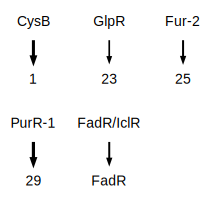

In [35]:
dots,links = compare_ica(ecoli_data.M, ica_data.M, cutoff=0.3,
                         ortho_file = '../example_data/example_bbh.csv')
dots

In the above plot, the top named iModulons are from *E. coli* and the bottom iModulons are from our target organism. Note that the two FadR iModulons are linked together. This `links` variable contains all pairs of iModulons that are linked together

In [36]:
links

[('GlpR', 23),
 ('PurR-1', 29),
 ('CysB', 1),
 ('Fur-2', 25),
 ('FadR/IclR', 'FadR')]

In [37]:
for ecoli_mod,target_mod in links:
    ica_data.imodulon_table.loc[target_mod,'ecoli_ortholog'] = ecoli_mod
ica_data.imodulon_table.head()

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene,ecoli_ortholog
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CysB
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
single_gene_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
ArnRAB,ArnR;ArnR1+ArnA;ArnB,1.209743e-19,3.662526e-19,1.0,0.875,0.933333,7.0,7.0,8.0,2.0,NaN,NaN


# Save iModulon object

This will save your iModulon table, your thresholds, and any other information stored in the ica_data object.

In [29]:
save_to_json(ica_data,'../data/p_syringae.json')

If you prefer to view and edit your iModulon table in excel, save it as a CSV and reload the iModulon as before

In [30]:
ica_data.imodulon_table.to_csv('../data/iModulon_table.csv')

# Coming soon

1. Saving GO/KEGG enrichments to iModulon table
1. Plotting iModulon gene weights across organisms
1. Using iModulon activities to characterize iModulons
1. Finding motifs using MEME
1. Building iModulonDB web pages
